# Optimal design for heteroscedastic polynomial models:

Given a compact design space $\mathcal{X}$ that have the form 
$$
    y(x)=g^\top(x) \beta+ \frac{e(x)}{\sqrt{\lambda(x)}}
$$


In [1]:
# Init
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.optimize import minimize

# === Settings ===
def g(x):
    return np.array([1, x, x**2])

def lambda_fn(x):
    return 2 * x + 5
    # return 1  # for homoscedastic case

tol = 1e-8
alpha = 0.5;
# === Used to find the optimal probability meausure mu^* ===
def compute_c_given_mu(mu, g_list, gz_mat, lambda_vals, M_inv, v_max):
    N = len(g_list)
    dim_A = gz_mat.shape[1]
    c = np.zeros(N)
    for i in range(N):
        gx = g_list[i]
        r = np.array([(gx @ M_inv @ gz_mat[:, j])**2 for j in range(dim_A)])
        c[i] = lambda_vals[i] * np.sum(mu * r) - v_max
    return c

## The Wrapper of objective function to be minimized using the optimizer
def objective(mu):
    c = compute_c_given_mu(mu, g_list, gz_mat, lambda_vals, M_inv, v_max)
    return np.max(c)

In [2]:
N = 501
Nz = 201
x_vals = np.linspace(-1, 1, N)
z_vals = np.linspace(-1, 1, Nz)
p = 3

g_list = [g(x) for x in x_vals]
lambda_vals = np.array([lambda_fn(x) for x in x_vals])
gz_list = [g(z).reshape(-1, 1) for z in z_vals]


# Multi-objective D- and G-optimal design (alpha = 0.5)
w = cp.Variable(N)
t = cp.Variable()

M = sum(w[i] * lambda_vals[i] * cp.outer(g_list[i], g_list[i]) for i in range(N))

constraints = [cp.sum(w) == 1, w >= 0]

for gz in gz_list:
    t_scalar = cp.reshape(t, (1, 1))
    gz_col = gz.reshape(-1, 1)
    gz_row = gz_col.T
    block_mat = cp.bmat([
        [t_scalar, gz_row],
        [gz_col,   M]
    ])
    constraints.append(block_mat >> 0)

# Multi-objective: alpha * G + (1 - alpha) * D
cvx_obj = cp.Minimize(alpha * t - (1 - alpha) * cp.log_det(M))
prob = cp.Problem(cvx_obj, constraints)

if 'MOSEK' in cp.installed_solvers():
    prob.solve(solver=cp.MOSEK, verbose=False)
else:
    prob.solve(solver=cp.SCS, eps=1e-9, max_iters=50000, verbose=False)

w_opt = w.value
support_idx = np.where(w_opt > 1e-4)[0]
x_out = np.round(x_vals[support_idx], 3)
w_out = np.round(w_opt[support_idx], 3)

print("Support points and weights (multi-objective):")
for xi, wi in zip(x_out, w_out):
    print(f"x = {xi:.3f}, weight = {wi:.3f}")

/Users/chikuang/yck_python_env/lib/python3.13/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


Support points and weights (multi-objective):
x = -1.000, weight = 0.460
x = 0.096, weight = 0.272
x = 1.000, weight = 0.268


## Compute directional derivative G-optimality

In [3]:
# === Step 3: Compute M_inv and v(z; ξ) ===
M_val = sum(w_opt[i] * lambda_vals[i] * np.outer(g_list[i], g_list[i]) for i in range(N))
M_inv = np.linalg.inv(M_val)

v_vals = np.array([gz.T @ M_inv @ gz for gz in gz_list])

# === Step 4: Identify A(ξ*) = {z ∈ Z | v(z) ≈ max v(z)} ===
v_max = np.max(v_vals)
max_indices = np.where(np.abs(v_vals - v_max) < tol)[0]
dim_A = len(max_indices)
gz_mat = np.column_stack([gz_list[j] for j in max_indices])

# === Step 5: Optimize μ* ===
Aeq = np.ones((1, dim_A))
beq = np.array([1])
bounds = [(0, 1)] * dim_A
mu0 = np.ones(dim_A) / dim_A

cons = {'type': 'eq', 'fun': lambda mu: np.sum(mu) - 1}
res = minimize(objective, mu0, method='SLSQP', bounds=bounds, constraints=cons, options={'disp': True})
mu_star = res.x
print("mu_star is:")
print(np.round(mu_star, 4))


# === Step 6: Compute φ_G(x) and directional derivative ===
phiG = np.array([gx.T @ M_inv @ gx for gx in g_list])
dphi = np.zeros(N)
for i in range(N):
    gx = g_list[i]
    r = np.array([(gx @ M_inv @ gz_mat[:, j])**2 for j in range(dim_A)])
    dphi[i] = lambda_vals[i] * np.sum(mu_star * r) - v_max

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2655290826257942
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7
mu_star is:
[0.6266 0.3734]


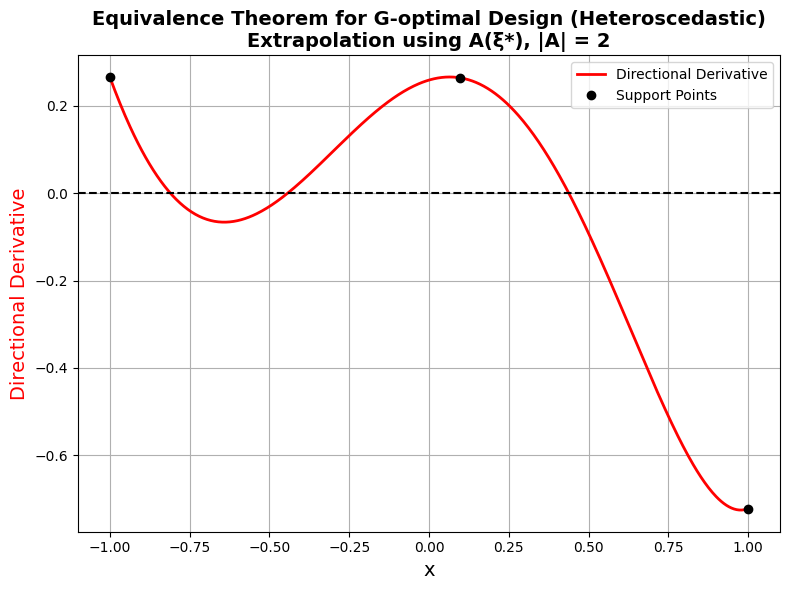

In [4]:
# === Step 7: Plot ===
plt.figure(figsize=(8, 6))
plt.plot(x_vals, dphi, 'r-', linewidth=2, label='Directional Derivative')
plt.plot(x_vals[support_idx], dphi[support_idx], 'ko', markersize=6, label='Support Points')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('x', fontsize=14)
plt.ylabel('Directional Derivative', fontsize=14, color='r')
plt.title(f'Equivalence Theorem for G-optimal Design (Heteroscedastic)\nExtrapolation using A(ξ*), |A| = {dim_A}', fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Compute directional derivative for D-optimality

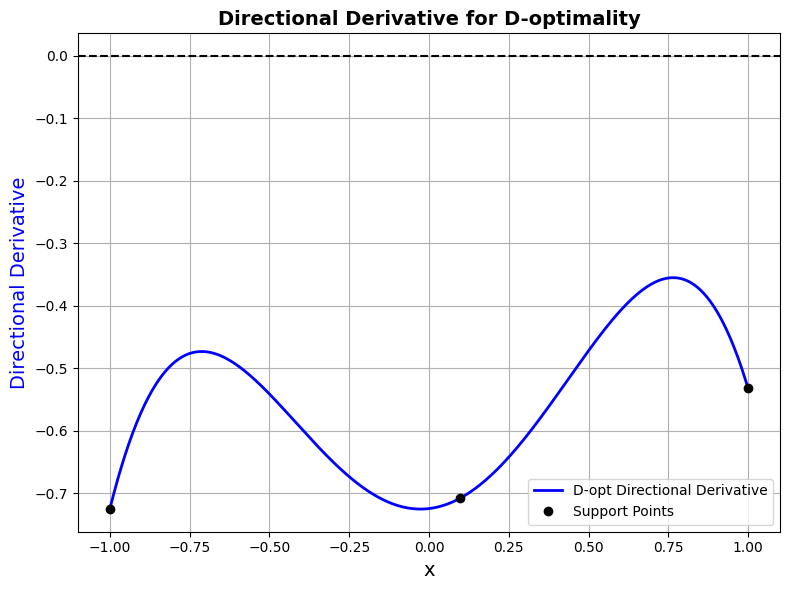

In [5]:
# === D-optimality Directional Derivative ===

# Recalculate M and its inverse using optimal weights
M_val = sum(w_opt[i] * lambda_vals[i] * np.outer(g_list[i], g_list[i]) for i in range(N))
M_inv = np.linalg.inv(M_val)

# Compute g(x)^T M^{-1} g(x) for each x
phiD = np.array([gx.T @ M_inv @ gx for gx in g_list])

# Compute directional derivative for D-optimality:
# dΦ_D(x) ∝ -trace(M^{-1} g(x)g(x)^T) = -g(x)^T M^{-1} g(x)
dphiD = -phiD

# === Plot ===
plt.figure(figsize=(8, 6))
plt.plot(x_vals, dphiD, 'b-', linewidth=2, label='D-opt Directional Derivative')
plt.plot(x_vals[support_idx], dphiD[support_idx], 'ko', markersize=6, label='Support Points')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('x', fontsize=14)
plt.ylabel('Directional Derivative', fontsize=14, color='b')
plt.title('Directional Derivative for D-optimality', fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

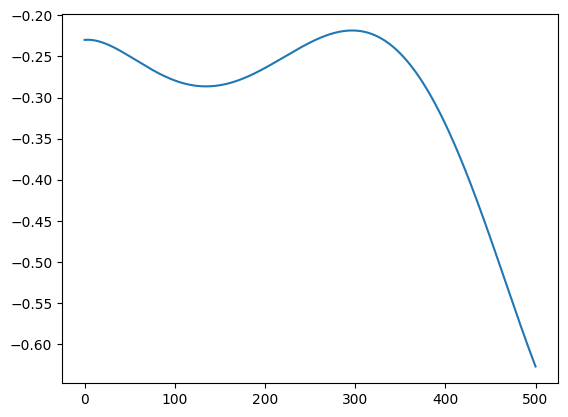

In [6]:
d_multi = alpha * dphi + (1-alpha)* dphiD;
plt.plot(d_multi)